## Introduction

For this journal we will attempt and fine tune a Random Forest Classifier to better detect sarcasm. We will continue to use the edited dataset from the previous journals, as well as use a TF-IDF vectorizer again.

First we will import our libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import string
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Then the dataset

In [2]:
df = pd.read_csv('/Users/lokikeeler/Downloads/train-balanced-sarcasm_2.csv')

In [3]:
df.head()

,label,comment,score,ups,downs,date,created_utc,parent_comment,year,SUB_2007scape,...,SUB_television,SUB_tf2,SUB_todayilearned,SUB_trees,SUB_ukpolitics,SUB_unitedkingdom,SUB_videos,SUB_worldnews,SUB_wow,SUB_xboxone
0,0,NC and NH.,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,False,...,False,False,False,False,False,False,False,False,False,False
1,0,You do know west teams play against west teams...,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,False,...,False,False,False,False,False,False,False,False,False,False
2,0,"They were underdogs earlier today, but since G...",3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016,False,...,False,False,False,False,False,False,False,False,False,False
3,0,"This meme isn't funny none of the ""new york ni...",-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016,False,...,False,False,False,False,False,False,False,False,False,False
4,0,"I don't pay attention to her, but as long as s...",0,0,0,2016-09-01,2016-09-02 10:35:08,do you find ariana grande sexy ?,2016,False,...,False,False,False,False,False,False,False,False,False,False


For consistency we will drop parent comment again

In [ ]:
df = df.drop(columns='parent_comment')

Here we will create our same tokenizer, still allowing for the uppercase letters as last time

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    stemmer = nltk.stem.PorterStemmer()
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'')

    listofwords = sentence.split(' ')
    listofstemmed_words = []

    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lokikeeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Again our we create our y (sarcasm label) and our X (everything else), then do a test/train split

In [10]:
X = df.drop(columns='label')
y = df['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
X_train.shape

(384932, 107)

Great. Now we can do our TFIDF again, but this time we use a max_features of 500. This will max our created vocabulary to 500 words, which makes the modeling faster and easier.

In [13]:
# using our custom tokenizer in TfidfVectorizer

tfidf = TfidfVectorizer(
                       
                        min_df=5,
                        max_features=500,
                        tokenizer=my_tokenizer, 
                        ngram_range=(1, 3)
                        )
tfidf.fit(X_train['comment'])

X_train_transformed = tfidf.transform(X_train['comment'])
X_test_transformed = tfidf.transform(X_test['comment'])

X_train_transformed.shape

/Users/lokikeeler/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(384932, 500)

Now we're ready to perform our random forest model. Let's first run it with no parameters and see how the accuracies compare between the train and test sets

In [33]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_transformed, y_train)

RandomForestClassifier()

In [34]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_train_transformed, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_test_transformed, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_train_transformed, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_test_transformed, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.7580817391123628
Random Forest: 0.8431385283634512
----------------
Performance on test data:
Average Decision Tree: 0.6046070242222923
Random Forest: 0.6413088281647795



Without applying any hyperparameters our model seems to be overfitting, scoring 84% on the train data and 64% on the test data. Let's try to reduce this by tweaking our model, but first we can look at our confusion matrix and other scores

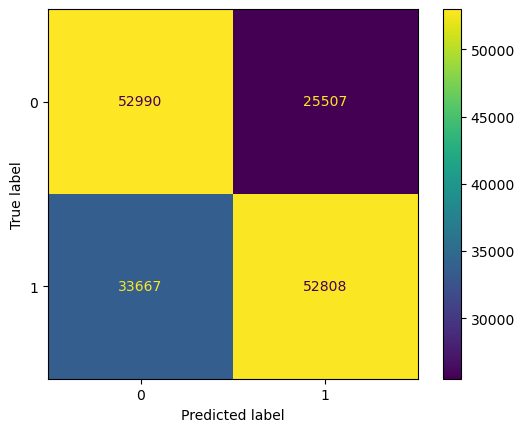

In [35]:
predictions = random_forest_model.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions, labels=random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=random_forest_model.classes_)
disp.plot()

plt.show()

In [36]:
y_pred = random_forest_model.predict(X_test_transformed)
accuracy = random_forest_model.score(X_test_transformed, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"The accuracy score is {accuracy}")
print(f"The precision score is {precision}")
print(f"The recall score is {recall}")

The accuracy score is 0.6413088281647795
The precision score is 0.674302496328928
The recall score is 0.6106736050881758


Our scores are looking pretty level here. Now let's reapeat this process, but add some hyperparameters to our random forest model. To improve run time, we will cap the number of trees in our forest to 50, allow no max depth, allow min samples split to be two so our tree can keep splitting as long as there are more than one sample at each node, and, lastly, allow for min samples leaf to be 1 so each split just needs a minimum of one sample.

In [14]:
random_forest_model_2 = RandomForestClassifier(
    n_estimators=50,
    n_jobs=-1,
    max_depth=None, 
    min_samples_split=2, 
    min_samples_leaf=1
    ) 
random_forest_model_2.fit(X_train_transformed, y_train)
 
#plot_decision_regions(X_train, y_train, clf=random_forest_model);

RandomForestClassifier(n_estimators=50, n_jobs=-1)

In [15]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model_2.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_train_transformed, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_test_transformed, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model_2.score(X_train_transformed, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model_2.score(X_test_transformed, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.7580657882431183
Random Forest: 0.8429956459842258
----------------
Performance on test data:
Average Decision Tree: 0.6045970225250344
Random Forest: 0.6394721528501807



Again we are overfitting. Let's see how our recall and precision scores have changed

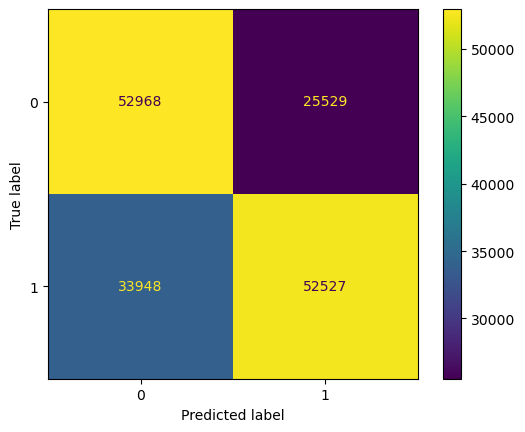

In [23]:
predictions = random_forest_model_2.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions, labels=random_forest_model_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=random_forest_model_2.classes_)
disp.plot()

plt.show()

In [27]:
y_pred = random_forest_model_2.predict(X_test_transformed)
accuracy = random_forest_model_2.score(X_test_transformed, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"The accuracy score is {accuracy}")
print(f"The precision score is {precision}")
print(f"The recall score is {recall}")

The accuracy score is 0.6394721528501807
The precision score is 0.6729485619114727
The recall score is 0.6074241110147441


Not much has changed here, only half a percent difference. Let's try again and experiment with different numbers. This time I will have no max_depth, and increase the min samples split to 10, and min samples leaf to 5

In [16]:
random_forest_model_3 = RandomForestClassifier(
    n_estimators=50,
    n_jobs=-1,
    max_depth=None,
    min_samples_split=10,  # Adjust the value based on experimentation
    min_samples_leaf=5  # Adjust the value based on experimentation
)
random_forest_model_3.fit(X_train_transformed, y_train)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=10,
                       n_estimators=50, n_jobs=-1)

In [17]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model_3.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_train_transformed, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_test_transformed, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model_3.score(X_train_transformed, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model_3.score(X_test_transformed, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.6550983550341359
Random Forest: 0.706239024035414
----------------
Performance on test data:
Average Decision Tree: 0.6175293989283029
Random Forest: 0.64613388938729



Here we can see some small progress: the accuracy improved by one percent, and our training set is only 6% better than our test data (rather than 20% as before). This indicates less overfitting, although we still are overfitting my a smudge. Let's check on our other scores

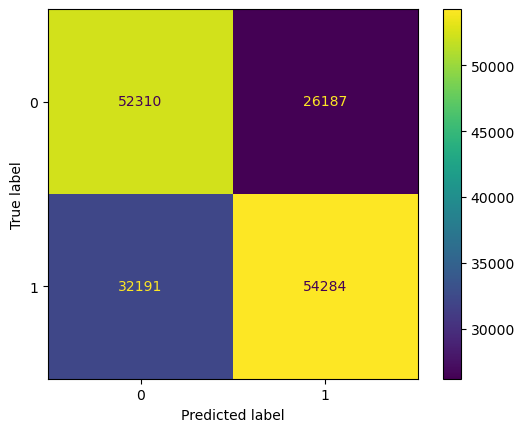

In [31]:
predictions = random_forest_model_3.predict(X_test_transformed)
cm = confusion_matrix(y_test, predictions, labels=random_forest_model_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=random_forest_model_3.classes_)
disp.plot()

plt.show()

In [32]:
y_pred = random_forest_model_2.predict(X_test_transformed)
accuracy = random_forest_model_2.score(X_test_transformed, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"The accuracy score is {accuracy}")
print(f"The precision score is {precision}")
print(f"The recall score is {recall}")

The accuracy score is 0.64613388938729
The precision score is 0.6745784195548707
The recall score is 0.6277421220005782


Here our recall score has improved by 1%, signifying we are are more correct with our positive predictions

## Conclusion

After using a TF IDF on our Comments, we were able to run a few different Random Forest models. Accuracy, precision, and recall scores all ranged in the 60-67 percentile with every model. As the first two models were significantly overfitted, our last model was only slightly overfitted. Furthermore, our last model had a slightly better recall and accuracy score. 